In [7]:
# imports
import cv2
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt


In [8]:
def hu_moments(image, quadrants=(1,1)):
    # Tamanho dos quadrantes
    width, height = image.shape[0], image.shape[1]
    part_width = width // quadrants[0]
    part_height = height // quadrants[1]
    
    # Calculate
    huMoments = list()
    for i in range(quadrants[0]):
        for j in range(quadrants[1]):
            #coordenadas da parte da imagem
            left = i * part_width
            upper = j * part_height
            right = left + part_width
            lower = upper + part_height

            # Retorna o quadrante da imagem
            quad = image[left:right, upper:lower]

            # Calculate Moments 
            moments = cv2.moments(quad)
            # Calculate Hu Moments
            huMoments.extend(cv2.HuMoments(moments).flatten())
            
    return huMoments

def black_pixels(image, quadrants=(1,1)):
    # Tamanho dos quadrantes
    width, height = image.shape[0], image.shape[1]
    part_width = width // quadrants[0]
    part_height = height // quadrants[1]

    counts = []
    for i in range(quadrants[0]):
        for j in range(quadrants[1]):
            #coordenadas da parte da imagem
            left = i * part_width
            upper = j * part_height
            right = left + part_width
            lower = upper + part_height

            # Retorna o quadrante da imagem
            part = image[left:right, upper:lower]

            # Contar os pixels pretos (assumindo que menores que 128 são pretos)
            black_pixels = np.sum(np.array(part) < 128)

            # Adicionar a contagem à lista
            counts.append(black_pixels)

    return counts

def get_files(caminho_p):
    file_dict = {}
    for pasta in Path(caminho_p).iterdir():
        if pasta.is_dir():
            file_dict[pasta.name] = []
            
            for file in Path(pasta).iterdir():
                if file.is_file() and (file.name.endswith(".png") or file.name.endswith(".jpg")):
                    file_dict[pasta.name].append(file)
    return file_dict

def createXy(database, quadrantes):
    X_hu, X_bp, y = list(), list(), list()

    for classe in database:
        for item in database[classe]:        
            image = cv2.imread(str(item), cv2.IMREAD_GRAYSCALE) #open img

        #hu
            X_hu.append(hu_moments(image, quadrantes))
            X_bp.append(black_pixels(image, quadrantes))
            y.append(classe)

    X_hu, X_bp, y = np.array(X_hu), np.array(X_bp), np.array(y)
    return X_hu,X_bp,y

def treino_teste_normalizado(X, y):
    StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    return X_train, X_test, y_train, y_test


def knn(neighbors, X_train, y_train, X_test):

    knn = KNeighborsClassifier(n_neighbors=neighbors, metric='euclidean')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred


def print_report(y_test, y_pred):
    print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
    # print('Precision Score: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    # print('Recall Score: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))


In [9]:
database = get_files('../fourShapes/')

params = {'neighbors': [2, 3, 5], 'quadrantes': [1, 2, 3, 4, 5] }
classes = ['circle', 'square', 'triangle']
ac_results_hu = {}
ac_results_bp = {}


for neighbor in params['neighbors']:
    for quadrante in params['quadrantes']:
        X_hu, X_bp, y = createXy(database, (quadrante, quadrante))
        X_hu_train, X_hu_test, y_hu_train, y_hu_test = treino_teste_normalizado(X_hu, y)
        X_bp_train, X_bp_test, y_bp_train, y_bp_test = treino_teste_normalizado(X_bp, y)

        inicio_hu = time.time()
        y_hu_pred = knn(neighbor, X_hu_train, y_hu_train, X_hu_test)
        fim_hu = time.time()

        inicio_bp = time.time()
        y_bp_pred = knn(neighbor, X_bp_train, y_bp_train, X_bp_test)
        fim_bp = time.time()
        
        # f1_results_hu.append(f1_score(y_hu_test, y_hu_pred, average='weighted'))
        # f1_results_bp.append(f1_score(y_bp_test, y_bp_pred, average='weighted'))
        ac_results_hu[f"V{neighbor} Q({quadrante}x{quadrante})"] = [round(accuracy_score(y_hu_test, y_hu_pred), 4), round(fim_hu - inicio_hu, 4)]
        ac_results_bp[f"V{neighbor} Q({quadrante}x{quadrante})"] = [round(accuracy_score(y_bp_test, y_bp_pred), 4), round(fim_bp - inicio_bp, 4)]
            
        print("===============================================================")
        print("KNN com {} vizinhos e {}x{} quadrantes".format(neighbor, quadrante, quadrante))
        print("HU")
        print_report(y_hu_test,y_hu_pred)
        print()
        print("BP")
        print_report(y_bp_test,y_bp_pred)


KNN com 2 vizinhos e 1x1 quadrantes
HU
Accuracy: 0.7625
F1 Score: 0.7567

BP
Accuracy: 0.7438
F1 Score: 0.7381
KNN com 2 vizinhos e 2x2 quadrantes
HU
Accuracy: 0.9313
F1 Score: 0.9307

BP
Accuracy: 0.9325
F1 Score: 0.9316
KNN com 2 vizinhos e 3x3 quadrantes
HU
Accuracy: 0.9237
F1 Score: 0.9230

BP
Accuracy: 0.9844
F1 Score: 0.9844
KNN com 2 vizinhos e 4x4 quadrantes
HU
Accuracy: 0.9300
F1 Score: 0.9289

BP
Accuracy: 0.9950
F1 Score: 0.9950
KNN com 2 vizinhos e 5x5 quadrantes
HU
Accuracy: 0.9700
F1 Score: 0.9700

BP
Accuracy: 0.9925
F1 Score: 0.9925
KNN com 3 vizinhos e 1x1 quadrantes
HU
Accuracy: 0.7806
F1 Score: 0.7807

BP
Accuracy: 0.7775
F1 Score: 0.7773
KNN com 3 vizinhos e 2x2 quadrantes
HU
Accuracy: 0.9400
F1 Score: 0.9398

BP
Accuracy: 0.9487
F1 Score: 0.9487
KNN com 3 vizinhos e 3x3 quadrantes
HU
Accuracy: 0.9363
F1 Score: 0.9355

BP
Accuracy: 0.9888
F1 Score: 0.9887
KNN com 3 vizinhos e 4x4 quadrantes
HU
Accuracy: 0.9319
F1 Score: 0.9306

BP
Accuracy: 0.9981
F1 Score: 0.9981
K

In [10]:
labels = []
resultados_hu = []
resultados_bp = []
tempo_hu = []
tempo_bp = []
# print(len(labels))
# print(labels)
for label in ac_results_bp:
    
    #print(label)
    labels.append(label)
    resultados_bp.append(ac_results_bp[label][0])
    resultados_hu.append(ac_results_hu[label][0])
    tempo_bp.append(ac_results_bp[label][1])
    tempo_hu.append(ac_results_hu[label][1])

    # print()

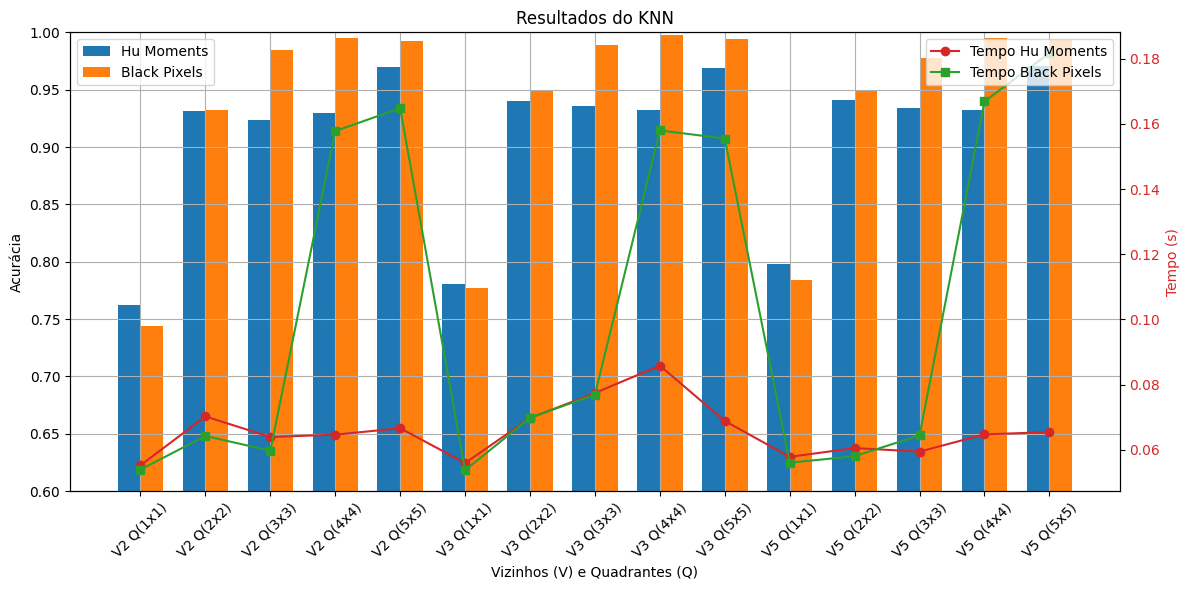

In [13]:
x = np.arange(len(labels))  # Localização dos rótulos
largura = 0.35  # Largura das barras

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)  # Largura
ax1.bar(x - largura/2, resultados_hu, largura, label='Hu Moments')
ax1.bar(x + largura/2, resultados_bp, largura, label='Black Pixels')
ax1.set_ylim(0.6, 1.0)  # Limites do eixo y

# Criar o segundo eixo para o tempo
ax2 = ax1.twinx()  # Eixo y compartilhado com ax1
ax2.plot(x, tempo_hu, color='tab:red', marker='o', label='Tempo Hu Moments')
ax2.plot(x, tempo_bp, color='tab:green', marker='s', label='Tempo Black Pixels')
ax2.set_ylabel('Tempo (s)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')  # Adiciona uma legenda para o segundo eixo


# Adicionar título, rótulos de eixo e legenda
ax1.set_title('Resultados do KNN')
ax1.set_ylabel('Acurácia')
ax1.set_xlabel('Vizinhos (V) e Quadrantes (Q)')
ax1.legend(loc='best')  # Adiciona uma legenda para o primeiro eixo

ax1.grid(True)  # Adicionar grades de fundo (opcional)
# Rotação dos rótulos para evitar sobreposição

ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
# ax1.set_xticklabels(labels)

# Exibir o gráfico
plt.tight_layout()  # Garante que tudo se encaixe corretamente
#plt.savefig('knn-results.png', bbox_inches='tight')
plt.show()

